# Optimization of The K Nearest Neighbors Model 


In this recitation you will use K Nearest Neighbors (K-NN) model to **optimize a binary classifier**.

Your main task would be to compare the performance of two K-NN classifiers that are based on the following two distance metrics:

- Minkowski
- Mahalanobis


You will investigate the following:
-	Effect of feature scaling (standardization)
-	Understanding covariance 
-	Which K-NN model (Minkowski or Mahalanobis distance metric) performs better when features have **high covariance**




## Note: Data Scaling
- Minkowski: If the feature scales vary, then you need to standardize the data during preprocessing
- Mahalanobis: No need to standardize the data during preprocessing

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import cov
from numpy.linalg import inv, matrix_rank, det, eig, cond


from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Create a Synthetic Dataset

We created a synthetic dataset that consists of datapoints from two classes (class 0 and 1).

These datapoints are generated from two 2D Gaussian distributions.

Observe that the 2D features have high covariance.

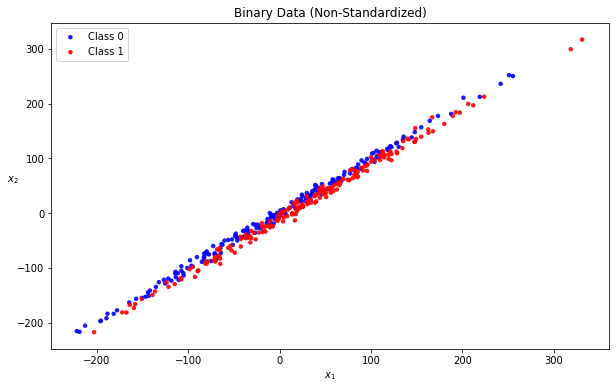

In [2]:
# The following binary classification dataset is created by drawing data from two 2D Gaussians
# Each data point has 2 features (dimensions)


# Mean and covariance for Class 0
mean0 = [10, 10]
cov0 = [[9500, 9480], [9480, 9500]]


# Number of datapoints for class 0
m0 = 200


# Generate class 0 data points from a multivariate (3D) Gaussian distribution
#    Here x0_1, x0_2 and x0_3 are 3 dimensions for each data (feature) point

x0_1, x0_2 = np.random.multivariate_normal(mean0, cov0, m0).T


# Concatenate the 3 dimensions of each feature to create the data matrix for class 0 
X0 = np.concatenate((x0_1.reshape(-1, 1), x0_2.reshape(-1, 1)), axis=1)

# Create the target vector for class 0 (target is coded with zero)
X0_target = np.zeros((m0,), dtype=np.int).reshape(-1, 1)



# Mean and covariance for Class 1
mean1 = [25, 15]
cov1 = [[9500, 9480], [9480, 9500]]

# Number of datapoints for class 1
m1 = 200


# Generate class 1 data points from a multivariate (3D) Gaussian distribution
#    Here x1_1, x1_2 and x1_3 are 2 dimensions for each data (feature) point
x1_1, x1_2 = np.random.multivariate_normal(mean1, cov1, m1).T

# Concatenate the 3 dimensions of each feature to create the data matrix for class 1
X1 = np.concatenate((x1_1.reshape(-1, 1), x1_2.reshape(-1, 1)), axis=1)

# Create the target vector for class 1 (target is coded with one)
X1_target = np.ones((m1,), dtype=np.int).reshape(-1, 1)


#  Class 0 and 1 data are combined to create a single data matrix X
X = np.append(X0, X1, axis=0)

# Target values for class 0 & 1 are combined to create a single target vector
y = np.concatenate((X0_target, X1_target), axis=0)





# Draw a scatter plot
fig = plt.figure(figsize=(10, 6))
plt.scatter(X0[:, 0], X0[:, 1],alpha=0.9, c="blue", edgecolors='none', s=20, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1],alpha=0.9, c="red", edgecolors='none', s=20, label="Class 1")
# plt.xlim(0,2)
# plt.ylim(0,500)
plt.title("Binary Data (Non-Standardized)")
plt.legend(loc=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.show()


## Investigate the Covariance Matrix and Its Properties

If a covariance matrix is singular, then its:
1. Determinant will be 0 (Note: determinant is the product of the eigenvalues; so if one or more eigvalues are zero, then the determinant will be zero)
2. It will not be positive definite (there will be zero eigenvalues)
3. It will suffer from rank deficiency (not full rank)




### Some Caveats of Numerical Algorithms:
- A covariance matrix is a real symmetric matrix, so its eigenvalues should be real. However, numerical algorithms that don't assume (or detect) that the matrix is symmetric might return small imaginary components due to roundoff error. 

- Due to the numerical algorithms, sometimes we might see that a matrix has full rank, but its determinant is zero. This happens due to rounding off issues in numerical algorithms.

- Also, sometimes we might see that a matrix has zero determinant (e.g., -0.0), but it's non-sigular (its inverse is defined). Again this happens due to the rounding off issue.

## Condition Number

When we observe a conflicting situation (zero determinant but full rank), we may compute the condition number of a matrix to identify its singularity.

If the condition number is very large, then the matrix is said to be ill-conditioned. Practically, such a matrix is almost singular, and the computation of its inverse, or solution of a linear system of equations is prone to large numerical errors. Super high condition number would mean that some variables are highly correlated. 

For the folowing calculations, we use following numpy functions:
- cov (from numpy)
- inv, matrix_rank, det, eig, cond (from numpy.linalg)

Note that the cov() function requires the transpose of the data matrix.

In [3]:
print("Dimension of X: ", X.shape)
print("\nRank of X: ", matrix_rank(X))


# Covariance of X
Sigma = cov(X.T)

print("\nCovariance of X:\n", Sigma)

print("\nDimension of the Covariance of X: ", Sigma.shape)

print("\nDeterminant of the Covariance of X: ", det(Sigma))


# Compute eigenvalues and eigenvectors 
eigenvalues, eigenvectors = eig(Sigma)


# Count the number of complex eigenvalues
noOfComplexEigenvalues = 0
for i in range(len(eigenvalues)):
    if isinstance(eigenvalues[i], complex):
        noOfComplexEigenvalues = noOfComplexEigenvalues + 1
        
print("\nNumber of complex eigenvalues: %d" % noOfComplexEigenvalues)



print("\nRank of the Covariance matrix: ", matrix_rank(Sigma))

#print("\nCovariance Matrix\n", Sigma)


condNum = cond(Sigma)
print("\nCondition Number of the Covariance matrix: ", condNum)


Dimension of X:  (400, 2)

Rank of X:  2

Covariance of X:
 [[8699.5083137  8580.32438086]
 [8580.32438086 8524.98990989]]

Dimension of the Covariance of X:  (2, 2)

Determinant of the Covariance of X:  541254.1145038918

Number of complex eigenvalues: 0

Rank of the Covariance matrix:  2

Condition Number of the Covariance matrix:  546.138739361437


# Create Test and Train Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into **random** train and test subsets.

For the reproducability of the results, we use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function. 

However, if we don't want to produce the same train and test subsets in repeated experiments, then we drop the "random_state" parameter from the funtion.


### Note: Target y

The target y is defined as a 1D vector. The sklearn KNeighborsClassifier model requires the target to be a 1D array. 

We use the numpy.ravel() function to create a flattened array from the 1D vector y.

We create seperate train-test sets for both the non-standardized and the standardized data.

In [4]:
# Convert the target as a 1D array
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(320, 2)
(80, 2)
(320,)
(80,)


# Covariance of Train & Test Data

For training a K-NN model using the Mahalanobis distance metric, we need to compute the data covariance & inverse of the covariance matrices.

For computing the inverse of the covariance matrix, first try the inv() function.

If you get "singular matrix" error, then try the pseudoinverse pinv() function.

## Task 1 (4 pts): 

Compute the following:

- Covariance matrix of X_train
- Determinant of the Covariance matrix of X_train
- Rank of the Covariance matrix of X_train
- Inverse of the Covariance matrix of X_train


In [11]:
# Covariance matrix of X_train

Sigma = cov(X_train.T)
print("\nCovariance of X:\n", Sigma)
# Determinant of the Covariance matrix of X_train

print("\nDeterminant of the Covariance of X: ", det(Sigma))


# Rank of the Covariance matrix of X_train

print("\nRank of the Covariance matrix: ", matrix_rank(Sigma))



# Inverse of the Covariance matrix of X_train

print("Inverse of Cov matrix: ", np.linalg.inv(Sigma)) #pinv if not able to compute inverse




Covariance of X:
 [[8668.04683934 8551.3462195 ]
 [8551.3462195  8497.70587769]]

Determinant of the Covariance of X:  532990.4090114901

Rank of the Covariance matrix:  2
Inverse of Cov matrix:  [[ 0.01594345 -0.01604409]
 [-0.01604409  0.01626304]]


## Minkowski Distance Metric: Model Selection

A K-NN model is defined by a set of parameters: nearest neighbors (K), distance metric (p), etc. These are called **hyperparameters**. We need to select the best model based on the optimal values of these hyperparameters. This process is called hyperparameter tuning.

The model parameters are known as **hyperparameters** because the values of these parameters are used to control the learning process. By contrast, the values of other parameters are learned. In the K-NN model there is no learning, thus we only tune the hyperparameters to create the optimal model

Hyperparameters are are passed as arguments to the constructor of the estimator classes. We search the hyperparameter space for the best cross validation score.


### Hyperparameter Tuning

The best way to do hyperparameter tuning is to use cross-validation.

We will use Scikit-Learn’s **GridSearchCV** to search the combinations of hyperparameter values that provide the best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation. 

We will tune the following hyperparameters of the GridSearchCV model.

- n_neighbors 
- weights 
- p 
    


### GridSearchCV Parameters

Following are the most frequenly used parameters by GridSearchCV.

- estimator : estimator object. This is assumed to implement the scikit-learn estimator interface. Either estimator needs to provide a score function, or scoring must be passed.

- param_grid : Dictionary with parameters names (string) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.

- scoring : string, callable, list/tuple, dict or None, default: None

    -- A single string (see The scoring parameter: defining model evaluation rules) or a callable (see Defining your scoring strategy from metric functions) to evaluate the predictions on the test set.


- n_jobs : int or None, optional (default=None). Number of jobs to run in parallel. 

    -- n_jobs= None means 1 unless in a joblib.parallel_backend context. 
   
    -- n_jobs = -1 means using all processors. 

- cv : int. Determines the cross-validation splitting strategy. None, to use the default 3-fold cross validation.

- verbose : integer. Controls the verbosity: the higher, the more messages.


### Note: the scoring function

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

In the binary classification, f1 score function can be used. We may also use the precision, recall, roc_auc functions.

## Task 2 (3 + 1 + 1 = 5 pts)

Do the following:
- Perform model selection using the Minkowski distance metric. Use the given "param_grid" values.
- Report best F1 score
- Report Optimal Hyperparameter Values

In [12]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values 
param_grid = {'n_neighbors': np.arange(1, 40, 2), 'p': [1, 2, 5, 10, 20, 30, 50, 100], 
              'weights': ["uniform", "distance"]}


knn_clf = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)

params_optimal_knn = knn_cv.best_params_












print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    2.0s


Best Score: 0.668835
Optimal Hyperparameter Values:  {'n_neighbors': 25, 'p': 50, 'weights': 'distance'}


Wall time: 2.57 s


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    2.4s finished


## Minkowski Distance Metric: Select The Best Model 

Using the optimal hyperparameter values, create the best model.

Then, fit the model.

## Task 3 (4 + 1 = 5 pts)

Do the following:
- Train a model using the optimal hyperparameter values
- Report training accuracy

In [13]:


knn = KNeighborsClassifier(**params_optimal_knn)
knn.fit(X_train, y_train) 

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)




print("\nTraining Accuracy: ",train_accuracy_knn)


Training Accuracy:  1.0


## Minkowski Distance Metric: Evaluate The Model Using Test Data

The KNeighborsClassifier model has a default "score" function that computes the accuracy of the model.

Often times the accuracy is not a good measure.

We also compute the other performance measures, such as the confusion matrix, precision, recall, and the F1 score for the test data.

## Task 4 (6 pts)

Do the following on the test data:
- Compute test accuracy
- Compute no. of correct predictions on test data
- Compute confusion matrix
- Compute precision, recall & F1 score

In [14]:

print("Evaluation of the KNN Model: Non-Standardized Data")

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))

precision = precision_score(y_test, y_test_predicted) 
print("\nPrecision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)

Evaluation of the KNN Model: Non-Standardized Data

Test Accuracy:  0.6375

No. of correct predictions (Test): 51/80

Confusion Matrix (Test Data):
 [[20 14]
 [15 31]]

Precision = 0.688889
Recall = 0.673913
F1 Score = 0.681319


# Mahalanobis Distance Metric


Note that the Mahalanobis distance metric works only with the brute force algorithm in sklearn. With this distance metric we tune only the following two hyperparameters.
- weights: "distance", "uniform"
- n_neighbors: int

Also the data should not be standardized before using the Mahalanobis distance metric.


## Mahalanobis Distance Metric: Model Selection

We cannot use GridSearchCV with the Mahalanobis distance metric.

Because for each iteration of the cross-validation by GridSearchCV, a new train fold is created which requires to compute the inverse of the feature covariance matrix.

With the sklearn grid search we cannot compute the inverse of the covariance matrix dynamically for each training fold.

Thus, we use the following code to search for the combination of the "weights" and "n_neighbors" hyperparameters with the Mahalanobis distance metric.

Note that the “metric_params” parameter is used to provide the feature covariance matrix.


## Task 5 (10 + 10 + 5 = 25 pts)

To train a K-NN model using the Mahalanobis distance metric, use the following template:

    knn_mahalanobis = KNeighborsClassifier(weights=?, algorithm='brute', n_neighbors=?, metric = "mahalanobis", 
                              metric_params={'V': ?})
                              
Here, the parameter $weights$ should be either "uniform" or "distance" and $metric\_params$ should be the covariance matrix of X_train.

Do the following.
- Use weights="uniform" & vary n_neighbors from 1 to 60 to compute a set of training accuracy and validation accuracy (use the cross_val_score function) values. Then plot these two accuracies against the values of n_neighbors.

- Use weights="distance" & vary n_neighbors from 1 to 60 to compute a set of training accuracy and validation accuracy (use the cross_val_score function) values. Then plot these two accuracies against the values of n_neighbors.

- Then, from the results obtained from the above two tasks determine an optimal pair of (a) n_neighbors & (b) weights. The optimal pair should be chosen based on maximum cross validation accuracy. 

In [16]:
##Same thing for weights = distance OR, include it on the loop
# weights = "uniform" & n_neighbors = range of Ks from 1 to 60
neighbors = np.arange(1,60)

# Two arrays to store training and test accuracies
train_accuracy = np.empty(len(neighbors))
validation_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(weights="uniform", algorithm='brute', n_neighbors=k, metric = "mahalanobis", 
                          metric_params={'V': Sigma})
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    
    # The "score" function returns the mean accuracy on the given train/test data and labels.
    # Note that "accuracy" may not be a good performance measure in a skewed data set
    # Thus, we need to do hyperparameter tuning by using better performance measures (e.g., f1 score, presision, recall)
    
    # Compute training accuracy 
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute validation accuracy using cross-validation
    
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    
    validation_accuracy[i] = scores.mean()

print("\nWeight: uniform")
print("Max K: ")
print("Max Validation Accuracy: ")




# weights = "distance" & n_neighbors = range of Ks from 1 to 60



print("\nWeight: distance")
print("Max K: ")
print("Max Validation Accuracy: ")






print("\nOptimal K: ")
print("Optimal weight: ")   
print("Optimal Validation Accuracy: ")   



Weight: uniform
Max K: 
Max Validation Accuracy: 

Weight: distance
Max K: 
Max Validation Accuracy: 

Optimal K: 
Optimal weight: 
Optimal Validation Accuracy: 


In [17]:
j = 0
max_val_accuracy = validation_accuracy[j]
max_k = 1

for i in neighbors:
    if(validation_accuracy[j] > max_val_accuracy):
        max_val_accuracy = validation_accuracy[j]
        max_k = i
    j +=1

print("\nWeight: uniform")
print("Max K: ",max_k)
print("Max Validation Accuracy: ",max_val_accuracy)


Weight: uniform
Max K:  13
Max Validation Accuracy:  0.815625


## Mahalanobis Distance Metric: Evaluation of the KNN Model 

## Task 6 (3 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 10  pts)

Do the following for the Mahalanobis distance metric based model:
- Train a model using the optimal hyperparameter values (weights & n_neighbors)
- Report training accuracy
- Compute test accuracy
- Compute no. of correct predictions on test data
- Compute confusion matrix
- Compute precision, recall & F1 score

In [32]:

#params_optimal_knn = {'n_neighbors': 13, 'weights': 'uniform', algorithm ='brute', metric = "mahalanobis", metric_params={'V': Sigma}}

#knn = KNeighborsClassifier(**params_optimal_knn)

knn_maha = KNeighborsClassifier(weights="uniform", algorithm='brute', n_neighbors=13, metric = "mahalanobis", 
                          metric_params={'V': Sigma})

knn_maha.fit(X_train, y_train)

y_train_predicted = knn_maha.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)





print("\nTraining Accuracy (Mahalanobis Distance): ")


print("\nTest Accuracy: ")



print("\nNo. of correct predictions (Test): ")




print("\nConfusion Matrix (Test Data):\n")


print("\nPrecision = ")


print("Recall = ")



print("F1 Score = ")


Training Accuracy:  0.81875

Training Accuracy (Mahalanobis Distance): 

Test Accuracy: 

No. of correct predictions (Test): 

Confusion Matrix (Test Data):


Precision = 
Recall = 
F1 Score = 


In [33]:
print("Evaluation of the KNN Model: Mahalanobis Distance")

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))

precision = precision_score(y_test, y_test_predicted) 
print("\nPrecision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)

Evaluation of the KNN Model: Mahalanobis Distance

Test Accuracy:  0.8125

No. of correct predictions (Test): 65/80

Confusion Matrix (Test Data):
 [[26  8]
 [ 7 39]]

Precision = 0.829787
Recall = 0.847826
F1 Score = 0.838710


# Function for Plotting Decision Bounday 


To better understand how the K Nearest Neighbors model classifier performs classifiation, we need to **<font color=red size=6> visualize </font>** its decision boundary.


We define the function "decision_boundary_class_colored" to plot the decision boundary. 

In [34]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()
    

## Decision Boundary: Minowski Distance vs Mahalanobis Distance

## Task 7 (4 + 1 = 5 pts): 

Do the following:
- Plot the decision boundaries on the given dataset by using two optimal models using Minkowski and Mahalanobis distance metrics
- On the title of the plots show the training and test accuracies

NameError: name 'train_accuracy_std_knn' is not defined

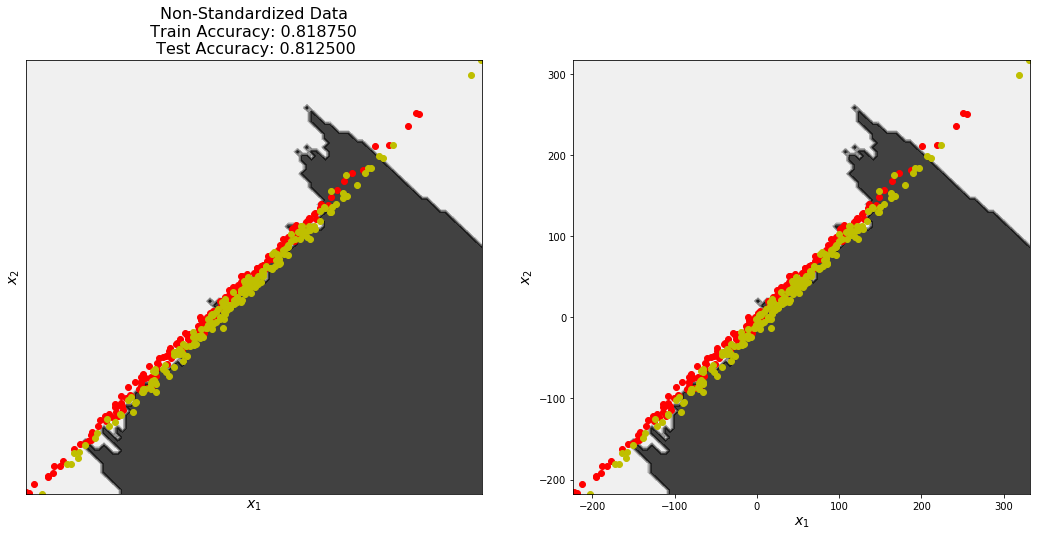

In [35]:

plt.figure(figsize=(18,8))

plt.subplot(121)
decision_boundary_class_colored(knn, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Non-Standardized Data\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_knn, test_accuracy_knn) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(knn_maha, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Standardized Data\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_std_knn, test_accuracy_std_knn) , fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()

In [52]:
plt.figure(figsize=(18,8))





<Figure size 1296x576 with 0 Axes>

<Figure size 1296x576 with 0 Axes>

Once you have completed the above tasks, run this notebook five times and fill out the following two tables. 

Before every run restart the notebook.

## Task 8 (10 pts):

Report Minkowski distance metric based optimal hyperparameter values (obtained from grid search cross-validation) and performance measures on test data.

In [53]:

minkowski = pd.DataFrame({"weights":["", "", "", "", ""], 
                   "n_neighbors":["", "", "", "", ""], 
                   "p":["", "", "", "", ""], 
                   "Accuracy":["", "", "", "", ""],
                   "Precision":["", "", "", "", ""],
                   "Recall":["", "", "", "", ""],
                   "F1 Score":["", "", "", "", ""]
                  })

minkowski

,Accuracy,F1 Score,Precision,Recall,n_neighbors,p,weights
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,


## Task 9 (10 pts):

Report Mahalanobis distance metric based optimal hyperparameter values (obtained from grid search cross-validation) and performance measures on test data.

In [39]:
import pandas as pd
mahalanobis = pd.DataFrame({"weights":["uniform", "", "", "", ""], 
                   "n_neighbors":["15", "", "", "", ""],  
                   "Accuracy":["0.813", "", "", "", ""],
                   "Precision":["0.83", "", "", "", ""],
                   "Recall":["0.849", "", "", "", ""],
                   "F1 Score":["0.839", "", "", "", ""]
                  })

mahalanobis

,weights,n_neighbors,Accuracy,Precision,Recall,F1 Score
0,uniform,15,0.813,0.83,0.849,0.839
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,


## Task 10 (10 pts):

Standardize the data and report Minkowski distance metric based optimal hyperparameter values (obtained from grid search cross-validation) and performance measures on test data.

In [55]:

minkowski_standardized = pd.DataFrame({"weights":["", "", "", "", ""], 
                   "n_neighbors":["", "", "", "", ""], 
                   "p":["", "", "", "", ""], 
                   "Accuracy":["", "", "", "", ""],
                   "Precision":["", "", "", "", ""],
                   "Recall":["", "", "", "", ""],
                   "F1 Score":["", "", "", "", ""]
                  })

minkowski_standardized

,Accuracy,F1 Score,Precision,Recall,n_neighbors,p,weights
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,


## Task 11 (5 pts)

Does standardization have any significant impact on the performance of the models? Justify your answer.

Answer:



Justification:

## Task 12 (5 pts)

Which distance metric (Minkowski or Mahalanobis) gave you better performance? Justify your answer (5pts).

Answer:





Justification:


## Score Distribution

- Task 1 (4 pts)
- Task 2 (3 + 1 + 1 = 5 pts)
- Task 3 (4 + 1 = 5 pts)
- Task 4 (6 pts)
- Task 5 (10 + 10 + 5 = 25 pts)
- Task 6 (3 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 10  pts)
- Task 7 (4 + 1 = 5 pts)
- Task 8 (10 pts)
- Task 9 (10 pts)
- Task 10 (10 pts)
- Task 11 (5 pts)
- Task 12 (5 pts)

Total = 100